In [139]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.dates as mdates
from matplotlib import rcParams
from statsmodels.tsa.stattools import acf,adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from warnings import filterwarnings

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

url = 'https://apis.data.go.kr/1480523/WaterQualityService/getWaterMeasuringList'
key = '8yJUJUA516mCT6EWW5qx4wczXHJvMSZEtuueDB3fhxlXBxkvLuvquPdwtP4CDBkmiHrbiKunquvt/K46xNulRw=='

In [21]:
# 주소에 있던 파라미터 그대로 설정
params = {
    'serviceKey': key,
    'pageNo': '1',
    'numOfRows': '3000',
    'resultType': 'json',
    'ptNoList': '2022A30,2022A10', # 측정소 코드
    'wmyrList': '2021,2022,2023,2024,2025',      # 연도
    'wmodList': '01,02,03,04,05,06,07,08,09,10,11,12'        # 월(01, 02, 03월)
}

try:
    # API 요청
    response = requests.get(url, params=params, verify=True) # https 대응
    
    if response.status_code == 200:
        data = response.json()
        
        # 데이터 추출 (구조: getWaterMeasuringList -> item)
        items = data.get('getWaterMeasuringList', {}).get('item', [])
        
        if items:
            df = pd.DataFrame(items)
            # df.set_index('ROWNO',inplace=True)

            # 주요 수질 항목 한글 이름으로 변경 (보기 좋게)
            rename_map = {
                'PT_NM': '총량지점명',
                'WMCYMD': '일자',
                'ITEM_TEMP': '수온', # 단위 : ℃
                'ITEM_PH': '수소이온농도(ph)',
                'ITEM_EC': '전기전도도(EC)',    # 단위 : μS/㎝
                'ITEM_DOC': '용존산소(DO)', # 단위 : ㎎/L
                'ITEM_BOD': 'BOD',  # 단위 : ㎎/L
                'ITEM_COD': 'COD',  # 단위 : ㎎/L
                'ITEM_SS': '부유물질',  # 단위 : ㎎/L
                'ITEM_TN': '총질소(T-N)',   # 단위 : ㎎/L
                'ITEM_TP': '총인(T-P)', # 단위 : ㎎/L
                'ITEM_TOC': '총유기탄소(TOC)',  # 단위 : ㎎/L
                'ITEM_AMNT': '유량',    # 단위 : ㎥/s
                'ITEM_CLOA': '클로로필-a'
            }
            
            # 필요한 컬럼만 추출하여 새 DF 생성
            waterDF = df[list(rename_map.keys())].copy()
            waterDF.rename(columns=rename_map, inplace=True)

            # 데이터 타입 숫자형으로 변환 (연산 가능하게)
            num_cols = ['수온', '수소이온농도(ph)', '전기전도도(EC)', '용존산소(DO)', 'BOD', 'COD', '부유물질', '총질소(T-N)', '총인(T-P)', '총유기탄소(TOC)', '유량','클로로필-a']
            waterDF[num_cols] = waterDF[num_cols].apply(pd.to_numeric, errors='coerce')

            # 날짜 데이터 형식 변환 (YYYYMMDD -> datetime)
            waterDF['일자'] = pd.to_datetime(waterDF['일자'], errors='coerce')

            print("--- 분석 준비 완료: 핵심 수질 지표 ---")
            print(waterDF.head())
        else:
            print("응답은 성공했으나 데이터가 없습니다.")
    else:
        print(f"API 요청 실패: {response.status_code}")

except Exception as e:
    print(f"오류 발생: {e}")

--- 분석 준비 완료: 핵심 수질 지표 ---
  총량지점명         일자   수온  수소이온농도(ph)  전기전도도(EC)  용존산소(DO)  BOD  COD  부유물질  \
0    물금 2021-01-04  4.6         7.5      437.0      13.1  1.7  5.1   2.4   
1    물금 2021-01-11  2.8         7.3      461.0      14.3  2.0  5.4   4.0   
2    물금 2021-01-26  5.1         7.2      470.0      15.6  2.1  6.0   7.6   
3    물금 2021-01-18  3.1         7.3      463.0      15.2  2.2  5.9   6.4   
4    물금 2021-02-16  6.6         8.4      451.0      12.1  2.8  6.6  12.4   

   총질소(T-N)  총인(T-P)  총유기탄소(TOC)      유량  클로로필-a  
0     3.223    0.025         3.8  29.555    12.4  
1     3.268    0.031         4.0  28.599    19.4  
2     3.416    0.026         4.6  74.897    47.3  
3     3.327    0.032         4.4  47.190    33.2  
4     3.489    0.027         5.0  72.735    50.4  


In [141]:
waterDF['년'] = waterDF['일자'].dt.year
waterDF['월'] = waterDF['일자'].dt.month
waterDF

,총량지점명,일자,수온,수소이온농도(ph),전기전도도(EC),용존산소(DO),BOD,COD,부유물질,총질소(T-N),총인(T-P),총유기탄소(TOC),유량,클로로필-a,년,월
0,물금,2021-01-04,4.6,7.5,437.0,13.1,1.7,5.1,2.4,3.223,0.025,3.8,29.555,12.4,2021,1
1,물금,2021-01-11,2.8,7.3,461.0,14.3,2.0,5.4,4.0,3.268,0.031,4.0,28.599,19.4,2021,1
2,물금,2021-01-26,5.1,7.2,470.0,15.6,2.1,6.0,7.6,3.416,0.026,4.6,74.897,47.3,2021,1
3,물금,2021-01-18,3.1,7.3,463.0,15.2,2.2,5.9,6.4,3.327,0.032,4.4,47.190,33.2,2021,1
4,물금,2021-02-16,6.6,8.4,451.0,12.1,2.8,6.6,12.4,3.489,0.027,5.0,72.735,50.4,2021,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,금곡,2025-09-23,25.4,7.7,285.0,7.8,1.3,6.9,6.4,1.928,0.055,3.6,357.260,17.4,2025,9
402,금곡,2025-09-09,28.6,8.6,219.0,7.6,1.7,8.6,9.6,1.579,0.059,6.1,340.400,52.6,2025,9
403,금곡,2025-10-13,23.3,8.4,288.0,9.0,1.6,7.0,7.6,1.858,0.041,3.4,443.810,39.5,2025,10
404,금곡,2025-10-27,19.0,7.8,192.0,9.5,1.1,6.4,6.4,2.719,0.082,3.2,443.180,20.4,2025,10


In [142]:
waterDF.select_dtypes(include='number').describe().T

,count,mean,std,min,25%,50%,75%,max
수온,404.0,18.056188,8.431139,2.800,10.67500,19.0000,25.22500,32.000
수소이온농도(ph),404.0,7.912376,0.536458,6.500,7.60000,7.9000,8.30000,9.200
전기전도도(EC),404.0,297.460396,107.355447,118.000,206.50000,279.5000,388.00000,516.000
용존산소(DO),404.0,10.372030,2.407574,6.600,8.40000,9.6000,11.92500,16.000
BOD,404.0,1.876485,0.723801,0.400,1.30000,1.7500,2.30000,4.400
COD,404.0,5.998515,1.082983,4.200,5.20000,5.9000,6.60000,11.600
부유물질,404.0,7.247277,7.381532,0.400,3.60000,6.0000,8.80000,100.800
총질소(T-N),404.0,2.449906,0.618431,0.804,2.04225,2.4205,2.91025,3.800
총인(T-P),404.0,0.042918,0.026786,0.015,0.02700,0.0335,0.04900,0.281
총유기탄소(TOC),404.0,3.973762,0.805721,2.100,3.40000,3.9000,4.50000,7.000


In [143]:
wd = waterDF.select_dtypes(include='number').corr()
wd

,수온,수소이온농도(ph),전기전도도(EC),용존산소(DO),BOD,COD,부유물질,총질소(T-N),총인(T-P),총유기탄소(TOC),유량,클로로필-a,년,월
수온,1.000000,0.120104,-0.672522,-0.888829,-0.025502,0.590225,0.285153,-0.652434,0.280791,0.407686,0.344139,0.066079,0.093061,0.448209
수소이온농도(ph),0.120104,1.000000,0.060053,0.124342,0.355301,0.248950,-0.098774,-0.349092,-0.477242,0.193473,-0.362927,0.522877,-0.036895,0.100557
전기전도도(EC),-0.672522,0.060053,1.000000,0.598234,0.233873,-0.334750,-0.326295,0.448558,-0.409117,-0.255261,-0.425005,-0.063253,-0.285601,-0.533178
용존산소(DO),-0.888829,0.124342,0.598234,1.000000,0.245966,-0.382175,-0.266339,0.546105,-0.365427,-0.234853,-0.410225,0.218189,-0.058692,-0.499017
BOD,-0.025502,0.355301,0.233873,0.245966,1.000000,0.472863,0.136457,0.066447,-0.051870,0.411794,-0.082820,0.520125,-0.021355,-0.412502
COD,0.590225,0.248950,-0.334750,-0.382175,0.472863,1.000000,0.459506,-0.367602,0.255526,0.788921,0.284284,0.494771,-0.047390,0.196426
부유물질,0.285153,-0.098774,-0.326295,-0.266339,0.136457,0.459506,1.000000,-0.170686,0.367831,0.343668,0.767870,0.240041,-0.085349,0.105157
총질소(T-N),-0.652434,-0.349092,0.448558,0.546105,0.066447,-0.367602,-0.170686,1.000000,0.086836,-0.100489,-0.149945,-0.156235,-0.031479,-0.485403
총인(T-P),0.280791,-0.477242,-0.409117,-0.365427,-0.051870,0.255526,0.367831,0.086836,1.000000,0.241748,0.479433,-0.126405,0.183828,0.100337
총유기탄소(TOC),0.407686,0.193473,-0.255261,-0.234853,0.411794,0.788921,0.343668,-0.100489,0.241748,1.000000,0.161918,0.467857,-0.109864,0.132803


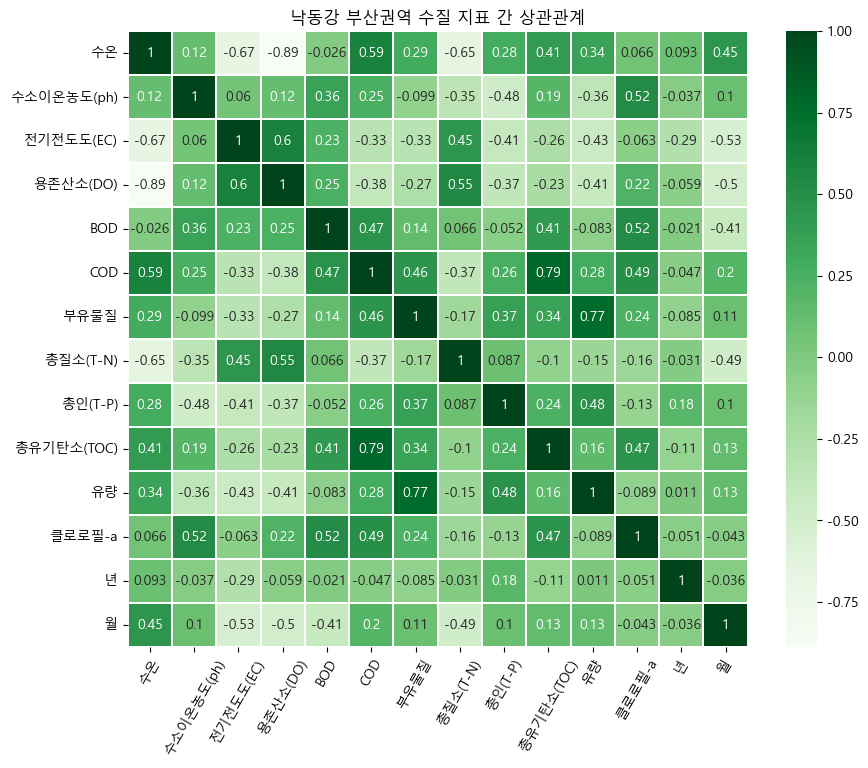

In [144]:
plt.figure(figsize=(10, 8))
sb.heatmap(wd, annot=True, linewidths=0.3, cmap='Greens')
plt.xticks(rotation=60)
plt.title("낙동강 부산권역 수질 지표 간 상관관계")
plt.show()

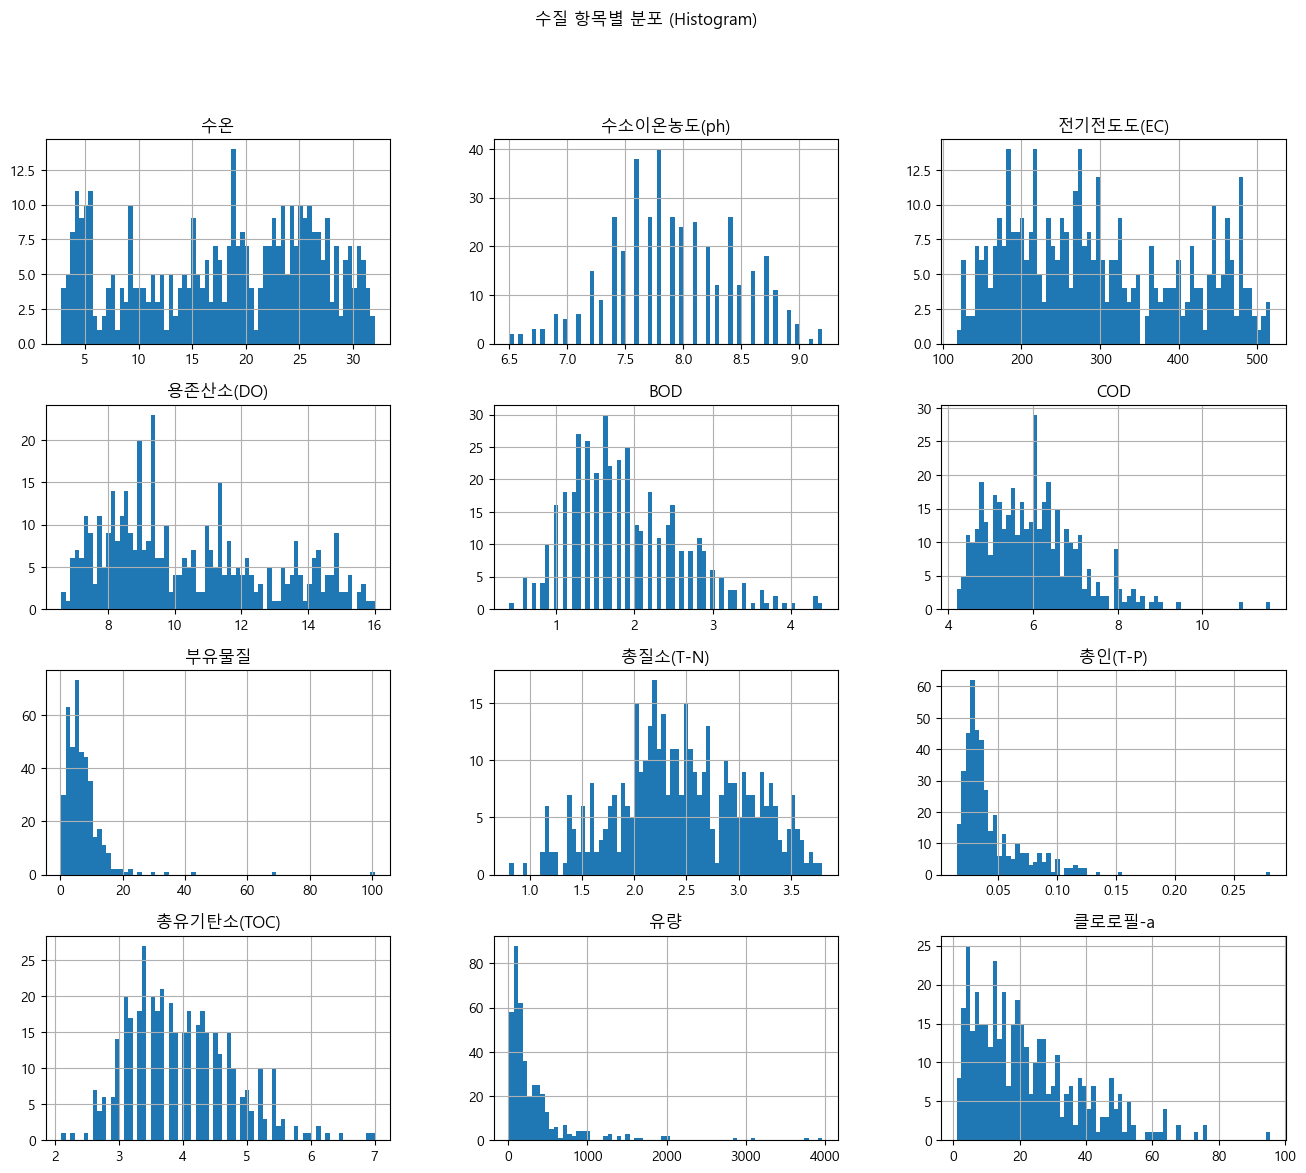

In [177]:
cols = ['수온', '수소이온농도(ph)', '전기전도도(EC)', '용존산소(DO)', 'BOD', 'COD', '부유물질', '총질소(T-N)', '총인(T-P)', '총유기탄소(TOC)', '유량', '클로로필-a']

waterDF[cols].hist(bins=70, figsize=(16, 13))
plt.suptitle('수질 항목별 분포 (Histogram)')
plt.show()

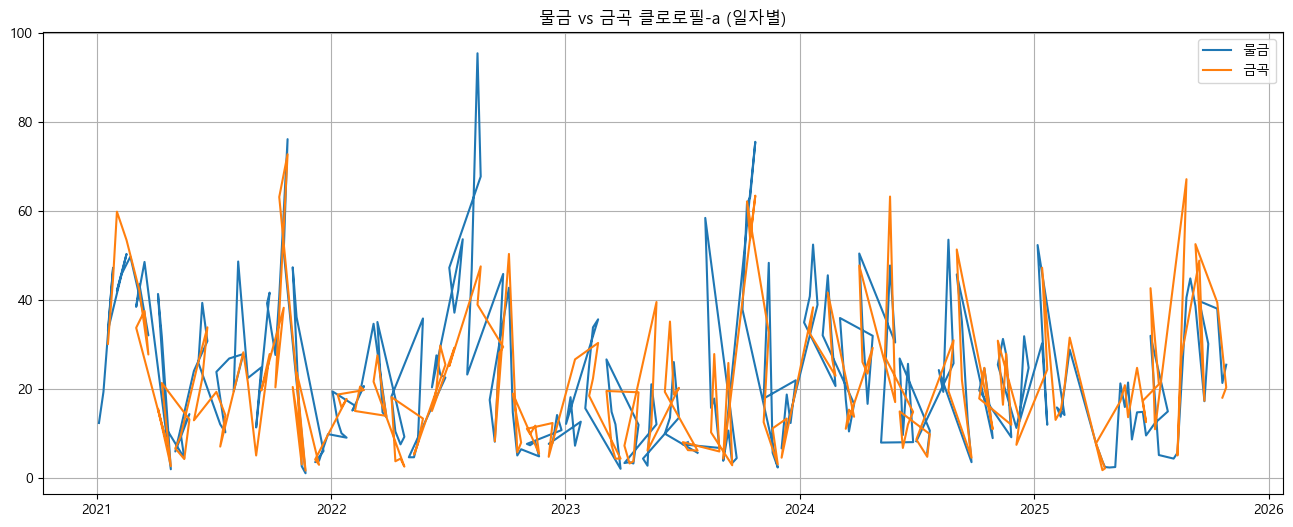

In [197]:
plt.figure(figsize=(16, 6))

mulgeumDf = waterDF[waterDF['총량지점명'] == '물금']
geumgogDf = waterDF[waterDF['총량지점명'] == '금곡']

plt.plot(mulgeumDf['일자'], mulgeumDf['클로로필-a'], label='물금')
plt.plot(geumgogDf['일자'], geumgogDf['클로로필-a'], label='금곡')
plt.grid(True)
plt.legend()
plt.title('물금 vs 금곡 클로로필-a (일자별)')
plt.show()

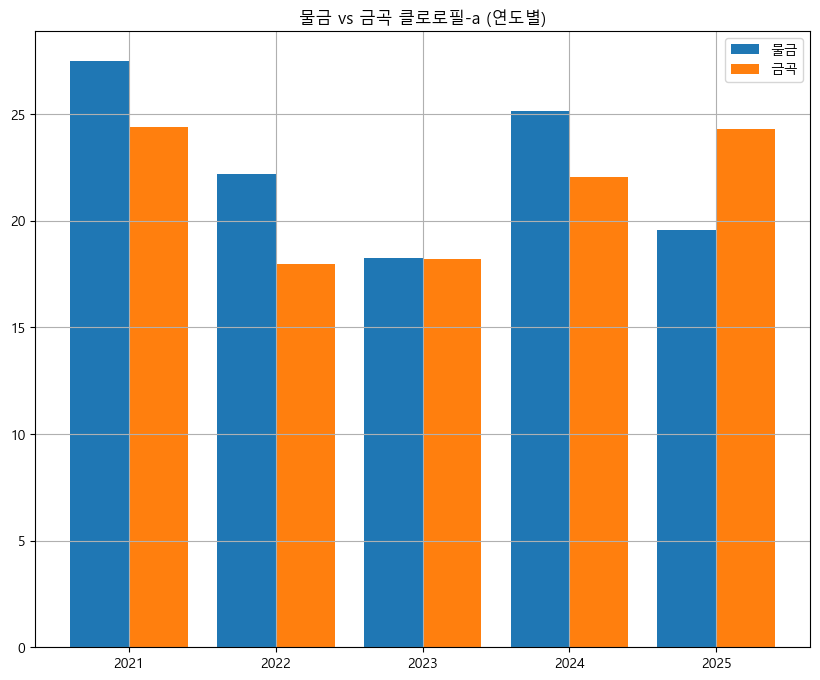

In [195]:
mulgeumDf_a = pd.DataFrame(mulgeumDf.groupby(['년'])['클로로필-a'].mean())
geumgogDf_a = pd.DataFrame(geumgogDf.groupby(['년'])['클로로필-a'].mean())

year = mulgeumDf_a.index.values 
x = np.arange(len(year))
width = 0.4

plt.figure(figsize=(10, 8))
plt.bar(x - width/2, mulgeumDf_a['클로로필-a'], width, label='물금')
plt.bar(x + width/2, geumgogDf_a['클로로필-a'], width, label='금곡')
plt.xticks(x, year)
plt.grid(True)
plt.legend()
plt.title('물금 vs 금곡 클로로필-a (연도별)')
plt.show()

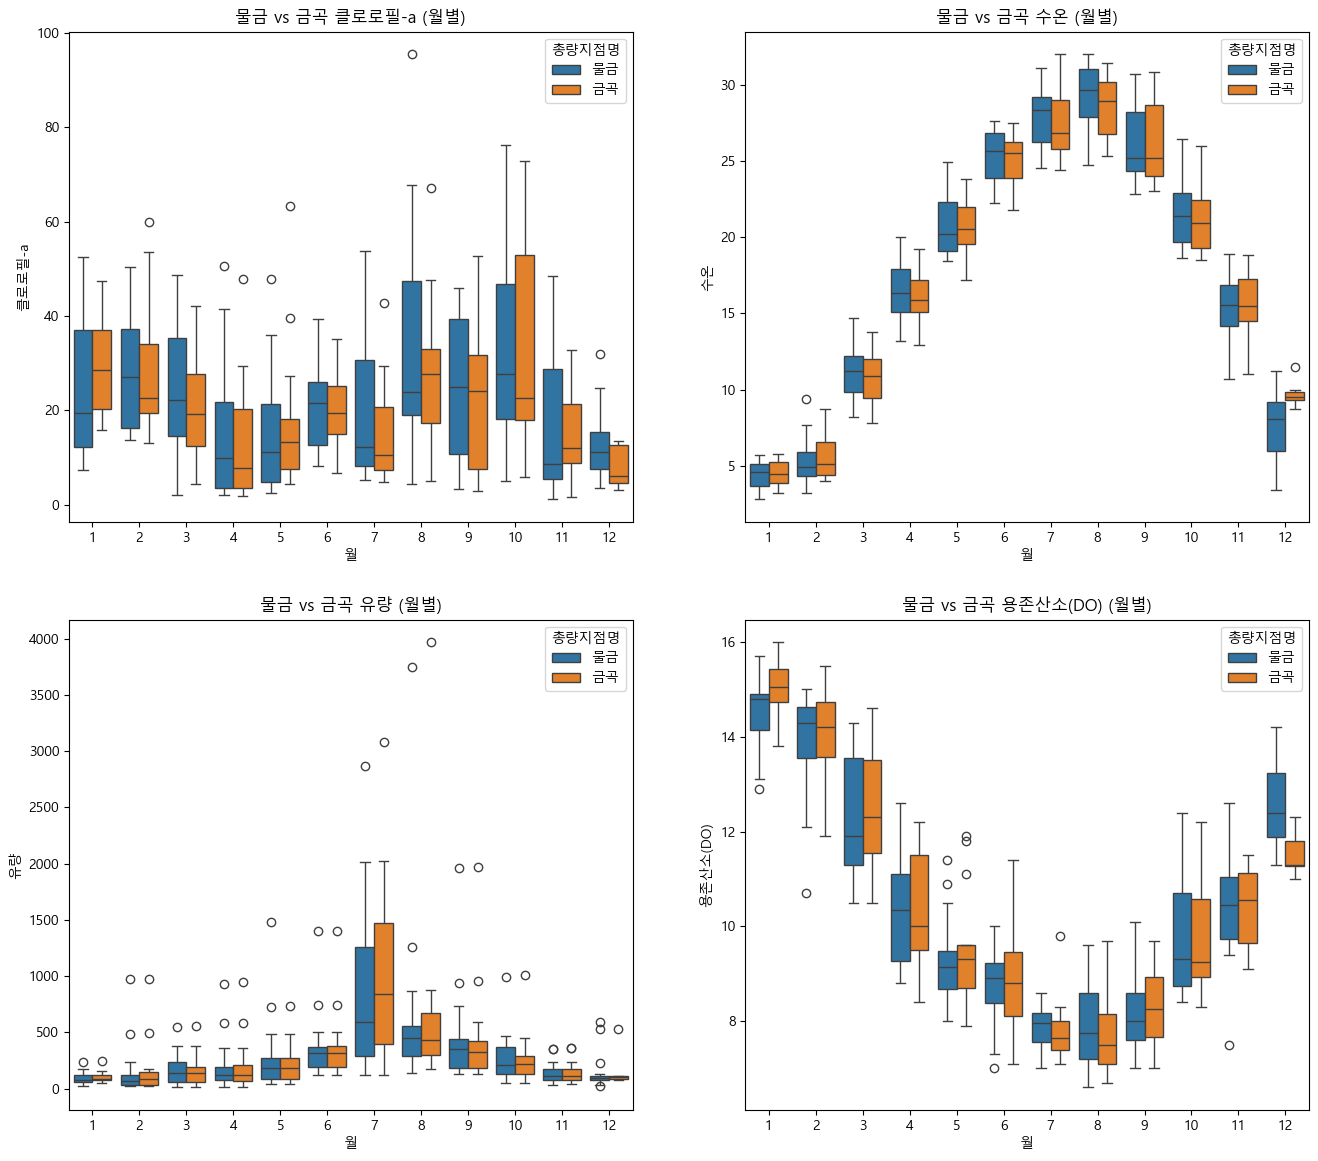

In [205]:
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

sb.boxplot(ax=axes[0,0], x='월', y='클로로필-a', hue='총량지점명', data=waterDF)
axes[0,0].set_title('물금 vs 금곡 클로로필-a (월별)')

sb.boxplot(ax=axes[0,1], x='월', y='수온', hue='총량지점명', data=waterDF)
axes[0,1].set_title('물금 vs 금곡 수온 (월별)')

sb.boxplot(ax=axes[1,0], x='월', y='유량', hue='총량지점명', data=waterDF)
axes[1,0].set_title('물금 vs 금곡 유량 (월별)')

sb.boxplot(ax=axes[1,1], x='월', y='용존산소(DO)', hue='총량지점명', data=waterDF)
axes[1,1].set_title('물금 vs 금곡 용존산소(DO) (월별)')

plt.show()